In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import prep_plays
import wrangle_plays_data


plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
week1 = pd.read_csv('week1.csv')
#plays = pd.read_csv('plays.csv')
#plays = pd.read_csv('plays.csv')

plays.head()

Acquire.py Loaded Successfully
Prep.py Loaded Successfully
Wrangle.py Loaded Successfully


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


In [2]:
plays = plays[plays.playType == 'play_type_pass']
plays['passResult'].replace({'C': 0,'I' : 1, 'IN' : 1}, inplace=True)

In [3]:
pd.set_option('display.max_columns',None)
plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,0,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,1,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,1,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,0,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,1,0,0,-0.842272,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18601,2018122201,3842,(2:19) (Shotgun) P.Rivers pass short right to ...,4,2,2,LAC,play_type_pass,LAC,33,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"1 DL, 5 LB, 5 DB",TRADITIONAL,22.0,10.0,02:19:00,77.0,NaN,NaN,0,7,7,0.460543,False
18602,2018122201,3884,(2:00) (Shotgun) P.Rivers pass short left to K...,4,1,10,LAC,play_type_pass,LAC,40,SHOTGUN,"1 RB, 1 TE, 3 WR",4.0,5.0,"1 DL, 4 LB, 6 DB",TRADITIONAL,22.0,10.0,02:00:00,70.0,NaN,NaN,0,17,17,0.712741,False
18603,2018122201,3909,(1:41) (Shotgun) P.Rivers pass incomplete shor...,4,1,10,LAC,play_type_pass,BAL,43,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,5.0,"1 DL, 4 LB, 6 DB",TRADITIONAL,22.0,10.0,01:41:00,53.0,NaN,NaN,1,0,0,-0.229687,False
18604,2018122201,3931,(1:37) (Shotgun) P.Rivers pass incomplete deep...,4,2,10,LAC,play_type_pass,BAL,43,SHOTGUN,"1 RB, 1 TE, 3 WR",4.0,4.0,"1 DL, 4 LB, 6 DB",TRADITIONAL,22.0,10.0,01:37:00,53.0,NaN,NaN,1,0,0,-0.460746,False


In [4]:
plays.typeDropback.value_counts()

TRADITIONAL               14816
SCRAMBLE_ROLLOUT_RIGHT     1019
DESIGNED_ROLLOUT_RIGHT      467
SCRAMBLE                    404
SCRAMBLE_ROLLOUT_LEFT       400
DESIGNED_ROLLOUT_LEFT       139
UNKNOWN                      95
Name: typeDropback, dtype: int64

In [5]:
plays10 = plays.head(10)

In [6]:
df = prep_plays.prep_plays_data()

In [7]:
pd.set_option('display.max_columns',None)
df

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,gameClock,absoluteYardlineNumber,epa,pass_stopped,playResult,RB,TE,WR,DL,LB,DB,EMPTY,I_FORM,JUMBO,PISTOL,SHOTGUN,SINGLEBACK,WILDCAT,four_three,three_four,nickel,dime
0,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,3,7.0,4.0,0.0,15:00:00,90.0,0.261827,0,10,2,1,2,4,2,5,0,1,0,0,0,0,0,0,0,1,0
1,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,3,7.0,4.0,0.0,13:10:00,49.0,-0.372360,1,0,1,1,3,4,2,5,0,0,0,0,0,1,0,0,0,1,0
2,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,3,6.0,4.0,0.0,13:05:00,49.0,-0.702779,1,0,2,1,2,4,2,5,0,0,0,0,1,0,0,0,0,1,0
3,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,3,6.0,5.0,1.0,13:01:00,49.0,3.047530,0,33,1,1,3,4,1,6,0,0,0,0,1,0,0,0,0,0,1
4,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,3,8.0,6.0,0.0,10:59:00,11.0,-0.842272,1,0,2,3,0,6,3,2,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,(2:19) (Shotgun) P.Rivers pass short right to ...,4,2,2,19,6.0,4.0,0.0,02:19:00,77.0,0.460543,0,7,1,1,3,1,5,5,0,0,0,0,1,0,0,0,0,1,0
17003,(2:00) (Shotgun) P.Rivers pass short left to K...,4,1,10,19,4.0,5.0,0.0,02:00:00,70.0,0.712741,0,17,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1
17004,(1:41) (Shotgun) P.Rivers pass incomplete shor...,4,1,10,19,5.0,5.0,0.0,01:41:00,53.0,-0.229687,1,0,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1
17005,(1:37) (Shotgun) P.Rivers pass incomplete deep...,4,2,10,19,4.0,4.0,0.0,01:37:00,53.0,-0.460746,1,0,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1


# Does a teams offense matter for a successful defensive pass interruption?

$H_o$ : A team's offense is not correlated to a defensive pass interruption.

$H_a$ : A team's offense is correlated with a defensive pass interruption.

$a$ : $.05$

Pearsonr Correlation Test
> Is there a linear relationship with team_by_comp_yds and pass_stopped?

Text(0.5, 1.0, '')

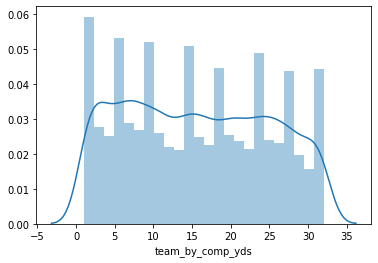

In [8]:
sns.distplot(df.team_by_comp_yds)
plt.title('')

In [9]:
corr, p = stats.pearsonr(df.team_by_comp_yds, df.pass_stopped)
corr, p
print('p:', p)
if p < .05:
    print('We reject the null hypothesis that there is no relationship with a teams offense and pass blocked.')
else:
    print('We fail to reject the null hypothesis.')

p: 2.029505834470611e-09
We reject the null hypothesis that there is no relationship with a teams offense and pass blocked.


In [10]:
#team_rank = plays.groupby('possessionTeam')[['offensePlayResult','passResult']].agg(list).sum().reset_index()
#team_rank

In [11]:
#df.plot(x='pass_stopped', y=['possessionTeam'])

In [12]:
team_pass = plays.groupby('possessionTeam').passResult.sum().reset_index()
team_pass = team_pass.sort_values(by='passResult', ascending=False)
team_pass.reset_index(drop=True, inplace=True)
teampass = team_pass.head(10)

In [13]:
def passing_team_rank():
    # brings in the plays csv
    plays = pd.read_csv('plays.csv')
    # returns only pass plays
    plays = plays[plays.playType == 'play_type_pass']
    # groups by team and sums the offense play result regardless of penalties
    team_rank = plays.groupby('possessionTeam')['offensePlayResult'].sum().reset_index()
    # sorts the summed results from highest to lowest
    team_rank = team_rank.sort_values(by='offensePlayResult', ascending=False)
    # returns the team rank
    return team_rank

In [14]:
team_rank = passing_team_rank()
team_rank10 = team_rank.head(10)
team_rank10

,possessionTeam,offensePlayResult
29,TB,5375
26,PIT,5189
1,ATL,4891
15,KC,4878
16,LA,4709
13,IND,4587
11,GB,4548
25,PHI,4534
20,NE,4422
22,NYG,4398


In [15]:
#team_rankpr = plays.groupby('possessionTeam')['passResult'].sum().reset_index()
    # sorts the summed results from highest to lowest
#team_rank = team_rank.sort_values(by='offensePlayResult', ascending=False)
    # returns the team rank

In [16]:
team_rank

,possessionTeam,offensePlayResult
29,TB,5375
26,PIT,5189
1,ATL,4891
15,KC,4878
16,LA,4709
13,IND,4587
11,GB,4548
25,PHI,4534
20,NE,4422
22,NYG,4398


In [17]:
team_rankn10 = team_rank.tail(10)

In [18]:
plays_rank = plays[['possessionTeam','passResult']]
#plays_rank['passResult'].replace({'C': 0,'I' : 1, 'IN' : 1}, inplace=True)
#plays_rank['team_rank'] = team_rank10.possessionTeam
plays_rank = plays.groupby('possessionTeam')['passResult'].sum().reset_index()

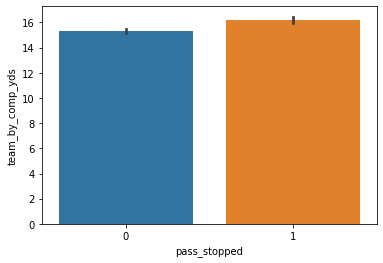

In [19]:
sns.barplot(data=df, x='pass_stopped', y= 'team_by_comp_yds')

In [20]:
plays_rank10 = plays_rank.head(10)

In [21]:
plays_rank

,possessionTeam,passResult
0,ARI,210
1,ATL,188
2,BAL,220
3,BUF,227
4,CAR,182
5,CHI,157
6,CIN,211
7,CLE,219
8,DAL,171
9,DEN,206


In [22]:
mergerank = pd.merge(left=team_rank, right=plays_rank,left_on='possessionTeam', right_on='possessionTeam')

In [23]:
mergerank = mergerank.sort_values(by=['passResult'], ascending=False)

In [24]:
mergerank10 = mergerank.head(10)
mergerank10

,possessionTeam,offensePlayResult,passResult
6,GB,4548,246
1,PIT,5189,228
30,BUF,3091,227
25,NYJ,3391,223
20,BAL,3677,220
10,CLE,4286,219
0,TB,5375,217
5,IND,4587,212
23,CIN,3575,211
31,ARI,2862,210


In [25]:
mergerankb10 = mergerank.tail(10)

Text(0, 0.5, 'Incomplete Passes')

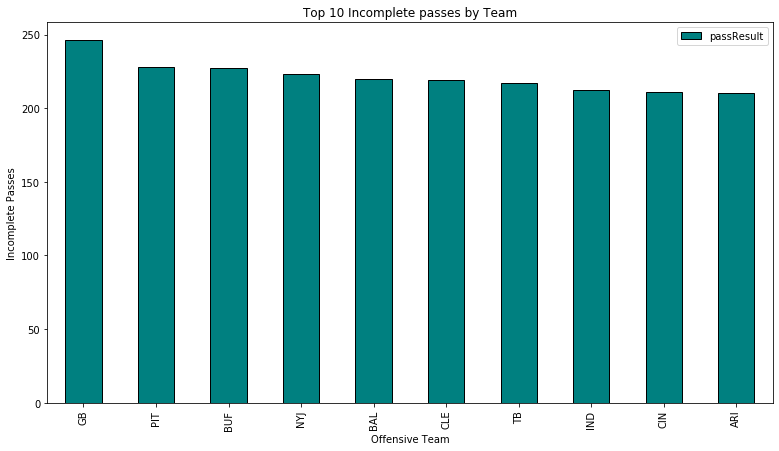

In [26]:
plt.rcParams['figure.figsize']=(13,7)
mergerank10.plot(x="possessionTeam", y="passResult", kind="bar", color='teal',edgecolor='black')
plt.title('Top 10 Incomplete passes by Team')
plt.xlabel('Offensive Team')
plt.ylabel('Incomplete Passes')


In [27]:
mms = MinMaxScaler()
mergerank[['offensePlayResult','passResult']] = mms.fit_transform(mergerank[['offensePlayResult','passResult']])

In [28]:
mergerank

,possessionTeam,offensePlayResult,passResult
6,GB,0.670911,1.000000
1,PIT,0.925985,0.842105
30,BUF,0.091126,0.833333
25,NYJ,0.210505,0.798246
20,BAL,0.324314,0.771930
10,CLE,0.566653,0.763158
0,TB,1.000000,0.745614
5,IND,0.686431,0.701754
23,CIN,0.283725,0.692982
31,ARI,0.000000,0.684211


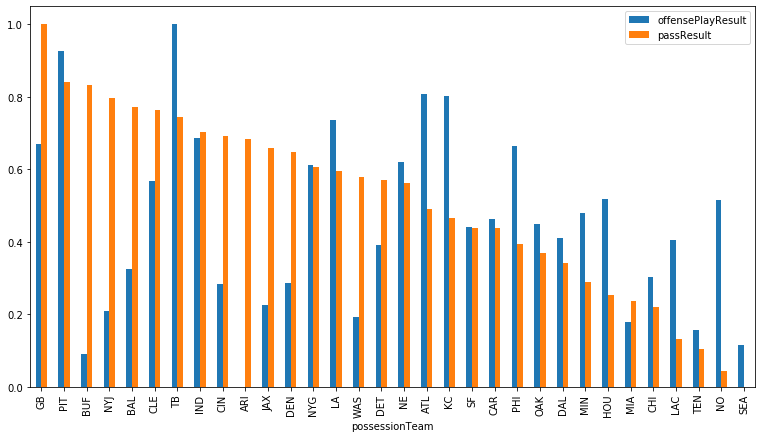

In [29]:
plt.rcParams['figure.figsize']=(13,7)
mergerank.plot(x="possessionTeam", y=["offensePlayResult", "passResult"], kind="bar")

In [30]:
plays20 = plays.head()

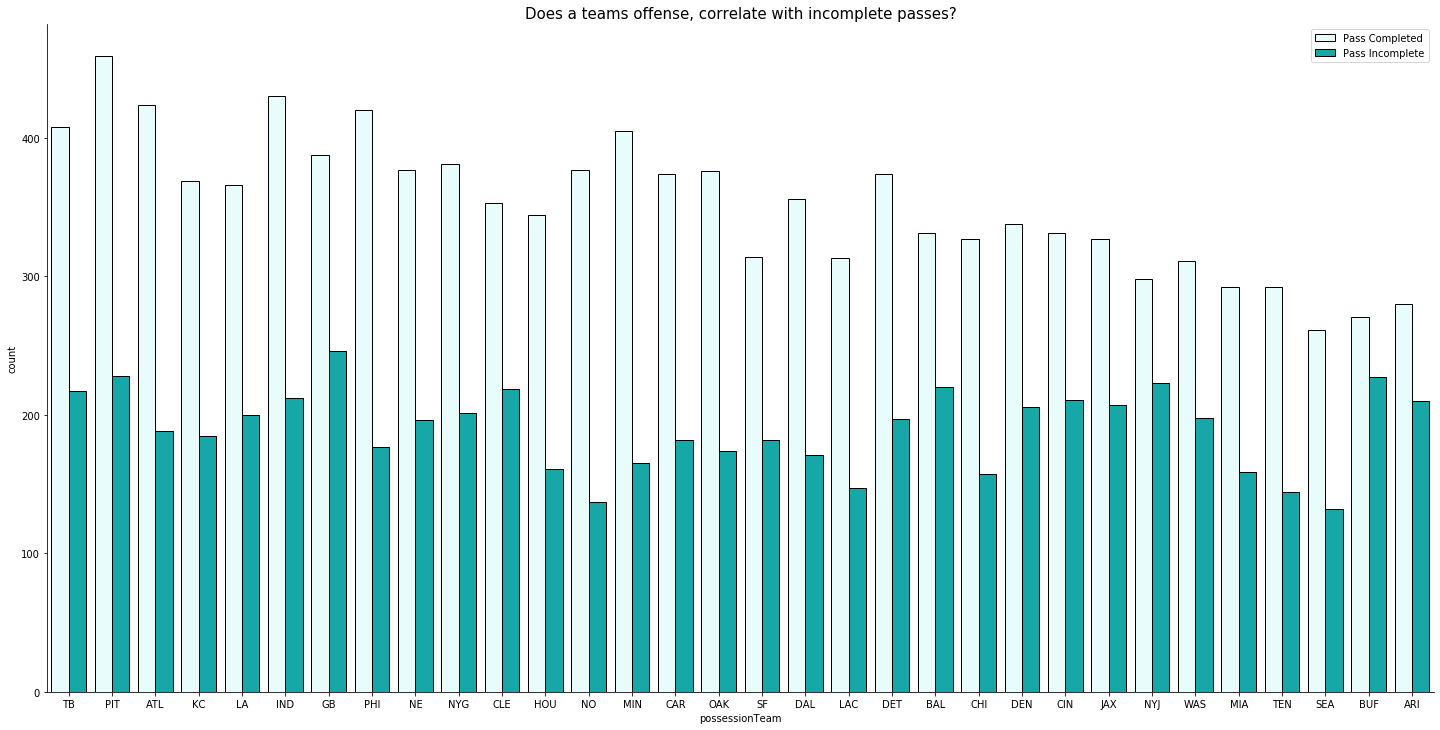

In [31]:
plot_order = plays.groupby('possessionTeam')['offensePlayResult'].sum().sort_values(ascending=False).index.values

sns.catplot(x="possessionTeam", hue="passResult", kind="count", data=plays, height=10, aspect=2,
            order = plot_order, color='c', ec='black')._legend.remove()
sns.color_palette = ('pastel')
plt.title('Does a teams offense, correlate with incomplete passes?', size = 15)
plt.legend(labels=('Pass Completed', 'Pass Incomplete'))

In [32]:
plays20

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,0,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,1,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,1,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,0,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,1,0,0,-0.842272,False


In [33]:
plays.groupby('possessionTeam')['offensePlayResult'].sum().sort_values(ascending=False).index.values

array(['TB', 'PIT', 'ATL', 'KC', 'LA', 'IND', 'GB', 'PHI', 'NE', 'NYG',
       'CLE', 'HOU', 'NO', 'MIN', 'CAR', 'OAK', 'SF', 'DAL', 'LAC', 'DET',
       'BAL', 'CHI', 'DEN', 'CIN', 'JAX', 'NYJ', 'WAS', 'MIA', 'TEN',
       'SEA', 'BUF', 'ARI'], dtype=object)

Text(0.5, 1.0, 'Top 10 offenses by pass completion yardage')

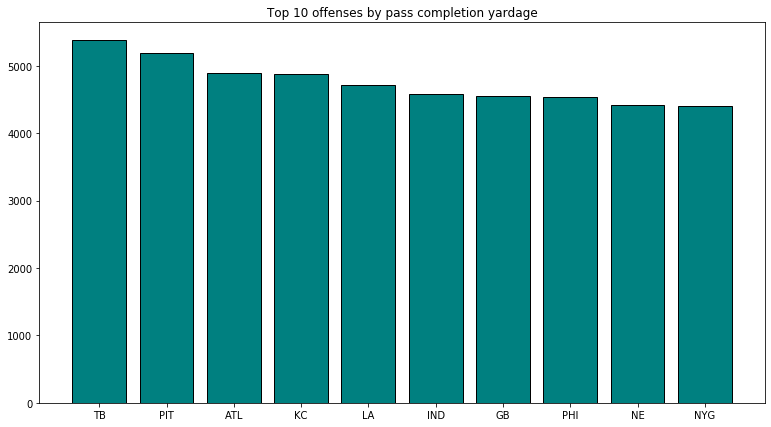

In [34]:
plt.rcParams['figure.figsize']=(13,7)
plt.bar(team_rank10.possessionTeam, team_rank10.offensePlayResult, color='teal', edgecolor='black')
plt.title('Top 10 offenses by pass completion yardage')

Text(0.5, 1.0, 'Top 10 offenses by pass completion yardage')

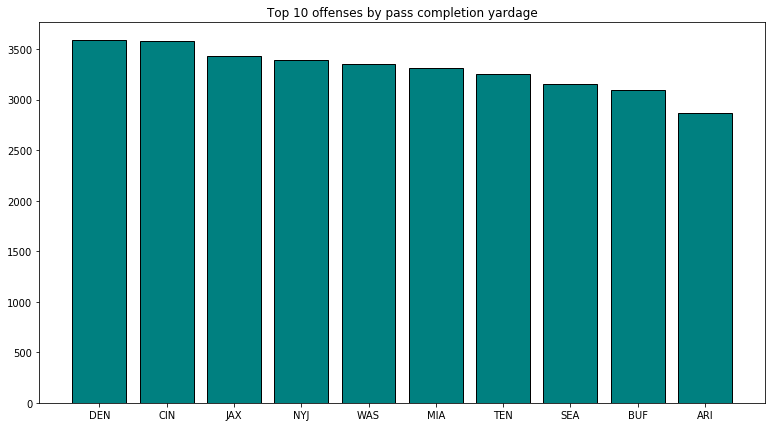

In [35]:
plt.rcParams['figure.figsize']=(13,7)
plt.bar(team_rankn10.possessionTeam, team_rankn10.offensePlayResult, color='teal', edgecolor='black')
plt.title('Top 10 offenses by pass completion yardage')

In [36]:
#x_order=['GB','PIT','BUF','NYJ','BAL','CLE','TB','IND','CIN','ARI','JAX','DEN','NYG',
#                    'LA','WAS','DET','NE','ATL','KC','CAR','SF','PHI','OAK','DAL','MIN',
#                    'HOU','MIA','CHI','LAC','TEN','NO','SEA'])

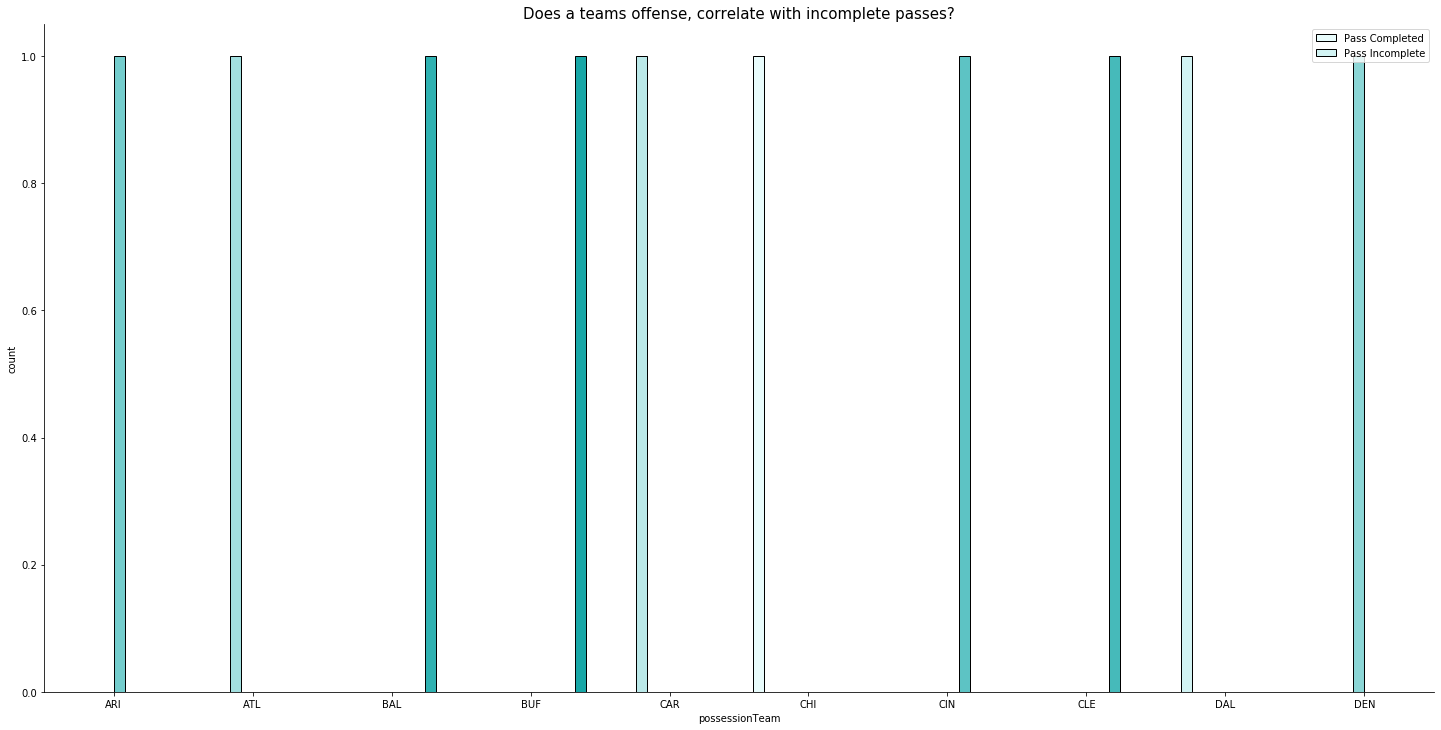

In [37]:
plt.rcParams['figure.figsize']=(30,20)
#plot_order = plays10.groupby('possessionTeam')['passResult'].sum().sort_values(ascending=False).index.values

sns.catplot(x="possessionTeam", hue="passResult", kind="count", data=plays_rank10, height=10, aspect=2,
            #order = plot_order,
            color ='c', ec='black')._legend.remove()
sns.color_palette = ('husl',8)
plt.title('Does a teams offense, correlate with incomplete passes?', size = 15)
plt.legend(labels=('Pass Completed', 'Pass Incomplete'))

In [38]:
plot_order

array(['TB', 'PIT', 'ATL', 'KC', 'LA', 'IND', 'GB', 'PHI', 'NE', 'NYG',
       'CLE', 'HOU', 'NO', 'MIN', 'CAR', 'OAK', 'SF', 'DAL', 'LAC', 'DET',
       'BAL', 'CHI', 'DEN', 'CIN', 'JAX', 'NYJ', 'WAS', 'MIA', 'TEN',
       'SEA', 'BUF', 'ARI'], dtype=object)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17001 entries, 0 to 17006
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   playDescription         17001 non-null  object 
 1   quarter                 17001 non-null  int64  
 2   down                    17001 non-null  int64  
 3   yardsToGo               17001 non-null  int64  
 4   team_by_comp_yds        17001 non-null  int64  
 5   defendersInTheBox       17001 non-null  float64
 6   numberOfPassRushers     17001 non-null  float64
 7   QB_under_pressure       17001 non-null  object 
 8   gameClock               17001 non-null  object 
 9   absoluteYardlineNumber  17001 non-null  float64
 10  epa                     17001 non-null  float64
 11  pass_stopped            17001 non-null  int64  
 12  playResult              17001 non-null  int64  
 13  RB                      17001 non-null  object 
 14  TE                      17001 non-null

____________________

# Logistic Regression Modeling
> All features except playDescription, and gameClock.

In [40]:
#X = df[['quarter', 'down', 'yardsToGo', 'team_by_comp_yds', 'defendersInTheBox',
#       'numberOfPassRushers', 'QB_under_pressure', 'absoluteYardlineNumber',
#       'epa', 'playResult', 'RB', 'TE', 'WR', 'DL', 'LB', 'DB', 'EMPTY',
#       'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT',
#       'four_three', 'three_four', 'nickel', 'dime']]

#X = df.drop(columns= ['playDescription','pass_stopped', 'gameClock','playResult','EMPTY', 'I_FORM', 'JUMBO',
#                                     'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT',
#                                     'RB', 'TE', 'WR'])

#X = df[['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers',
#       'QB_under_pressure', 'epa', 'playResult', 'RB', 'TE', 'WR', 'DL', 'LB',
#       'DB', 'EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK']]

##### BEST features for Logistic regression
X = df.drop(columns= ['playDescription','pass_stopped', 'gameClock'])

###### BEST features for KNN
#X = df[['yardsToGo', 'numberOfPassRushers', 'epa', 'playResult', 'RB',
#        'EMPTY', 'I_FORM', 'PISTOL', 'SHOTGUN', 'SINGLEBACK']]

#X = df[['yardsToGo', 'numberOfPassRushers', 'epa', 'playResult', 'RB']]

y = df[['pass_stopped']]

In [41]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size = .40, random_state = 123)

print("train: ", X_train.shape, ", validate: ", X_validate.shape, ", test: ", X_test.shape)
print("train: ", y_train.shape, ", validate: ", y_validate.shape, ", test: ", y_test.shape)

train:  (7140, 27) , validate:  (4760, 27) , test:  (5101, 27)
train:  (7140, 1) , validate:  (4760, 1) , test:  (5101, 1)


In [42]:
scaler = MinMaxScaler(copy = True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns.values).set_index([X_train.index.values])
X_validate_scaled = pd.DataFrame(X_validate_scaled, columns = X_validate.columns.values).set_index([X_validate.index.values])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns.values).set_index([X_test.index.values])

In [43]:
# creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_train)

y_pred_proba = logit.predict_proba(X_train)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on TRAIN-unscaled set: {:.2f}'
     .format(logit.score(X_train, y_train)))

print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))
print('')
############
print('***** VALIDATE *****')

#logit.fit(X_validate, y_validate)

#LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
#                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_validate)

y_pred_proba = logit.predict_proba(X_validate)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on VALIDATE-unscaled set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))
print('')
##########
print('***** TEST *****')

# fit the model
#logit.fit(X_test, y_test)

#LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
#                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_test)

y_pred_proba = logit.predict_proba(X_test)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on TEST-unscaled set: {:.2f}'
     .format(logit.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Coefficient: 
 [[ 2.32900036e-02  6.92445489e-01  1.36086206e-01  2.39609129e-02
   5.44998455e-02  2.05742761e-01  5.27059805e-01  7.61284119e-04
   1.91081636e-03 -7.04026707e-01 -3.24821109e-01  1.94652236e-01
   1.34681207e-01 -1.73177175e-01 -2.75855119e-01  5.17398999e-01
  -6.20308981e-01  1.21670919e-01  9.21105235e-02 -2.03836618e-01
  -9.17188046e-02  4.58944425e-02  0.00000000e+00  5.46865373e-02
   1.47333893e-01 -4.92340151e-02 -1.28087376e+00]]
Intercept: 
 [0.00566212]
>>>>>>>>>> Accuracy of Logistic Regression classifier on TRAIN-unscaled set: 0.73
[[2660 1946]
 [   6 2528]]
              precision    recall  f1-score   support

           0       1.00      0.58      0.73      4606
           1       0.57      1.00      0.72      2534

    accuracy                           0.73      7140
   macro avg       0.78      0.79      0.73      7140
weighted avg       0.84      0.73      0.73      7140


***** VALIDATE *****
Coefficient: 
 [[ 2.32900036e-02  6.92445489e-01  1.3

In [44]:
# SCALED creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_train_scaled)

y_pred_proba = logit.predict_proba(X_train_scaled)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on TRAIN set: {:.2f}'
     .format(logit.score(X_train_scaled, y_train)))
print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))
print('')
##########
print('***** VALIDATE *****')
#logit.fit(X_validate_scaled, y_validate)

#LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
#                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_validate_scaled)

y_pred_proba = logit.predict_proba(X_validate_scaled)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on VALIDATE set: {:.2f}'
     .format(logit.score(X_validate_scaled, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))
print('')
##########
print('***** TEST *****')
#logit.fit(X_test_scaled, y_test)

#LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
#                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_test_scaled)

y_pred_proba = logit.predict_proba(X_test_scaled)

print('>>>>>>>>>> Accuracy of Logistic Regression classifier on TEST set: {:.2f}'
     .format(logit.score(X_test_scaled, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))


Coefficient: 
 [[ 8.52941125e-02  3.92004765e-01  8.99226435e-01  3.96889185e-01
   1.26938592e-01  1.74263091e+00  5.69131726e-01  1.49194288e-02
  -1.71751881e+01 -5.18103034e+01  1.64238070e+00  2.84316503e+00
   3.57859406e+00  2.27653223e+00  2.06703238e+00  7.23366743e+00
  -1.99300266e+00 -1.63495186e+00 -2.27874839e-01 -2.44529404e+00
  -1.73297189e+00 -1.78675645e+00  0.00000000e+00 -4.01729313e-01
  -3.02157077e-01 -8.26265543e-01 -1.75196469e+00]]
Intercept: 
 [26.06873115]
>>>>>>>>>> Accuracy of Logistic Regression classifier on TRAIN set: 0.63
[[1993 2613]
 [   5 2529]]
              precision    recall  f1-score   support

           0       1.00      0.43      0.60      4606
           1       0.49      1.00      0.66      2534

    accuracy                           0.63      7140
   macro avg       0.74      0.72      0.63      7140
weighted avg       0.82      0.63      0.62      7140


***** VALIDATE *****
Coefficient: 
 [[ 8.52941125e-02  3.92004765e-01  8.99226435e

# KNN modeling

In [45]:
# TRAIN creating object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

y_pred = knn.predict(X_train_scaled)

y_pred_proba = knn.predict_proba(X_train_scaled)

print('>>>>>>>>>> Accuracy of KNN classifier on TRAIN set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))

print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))

print('')

print('***** VALIDATE *****')

#knn.fit(X_validate_scaled, y_validate)

#KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     #metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     #weights='uniform')

y_pred = knn.predict(X_validate_scaled)

y_pred_proba = knn.predict_proba(X_validate_scaled)

print('>>>>>>>>>> Accuracy of KNN classifier on VALIDATE set: {:.2f}'
      .format(knn.score(X_validate_scaled, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))

print('')

print('***** TEST *****')

#knn.fit(X_test_scaled, y_test)

#KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     #metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     #weights='uniform')

y_pred = knn.predict(X_test_scaled)

y_pred_proba = knn.predict_proba(X_test_scaled)

print('>>>>>>>>>> Accuracy of KNN classifier on TEST set: {:.2f}'
      .format(knn.score(X_test_scaled, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

>>>>>>>>>> Accuracy of KNN classifier on TRAIN set: 0.80
[[4155  451]
 [ 993 1541]]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      4606
           1       0.77      0.61      0.68      2534

    accuracy                           0.80      7140
   macro avg       0.79      0.76      0.77      7140
weighted avg       0.80      0.80      0.79      7140


***** VALIDATE *****
>>>>>>>>>> Accuracy of KNN classifier on VALIDATE set: 0.69
[[2584  579]
 [ 919  678]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      3163
           1       0.54      0.42      0.48      1597

    accuracy                           0.69      4760
   macro avg       0.64      0.62      0.63      4760
weighted avg       0.67      0.69      0.67      4760


***** TEST *****
>>>>>>>>>> Accuracy of KNN classifier on TEST set: 0.68
[[2683  602]
 [1048  768]]
              precision    recall  f1-score   suppor

([<matplotlib.axis.XTick at 0x7fd170e2a990>,
 <a list of 5 Text xticklabel objects>)

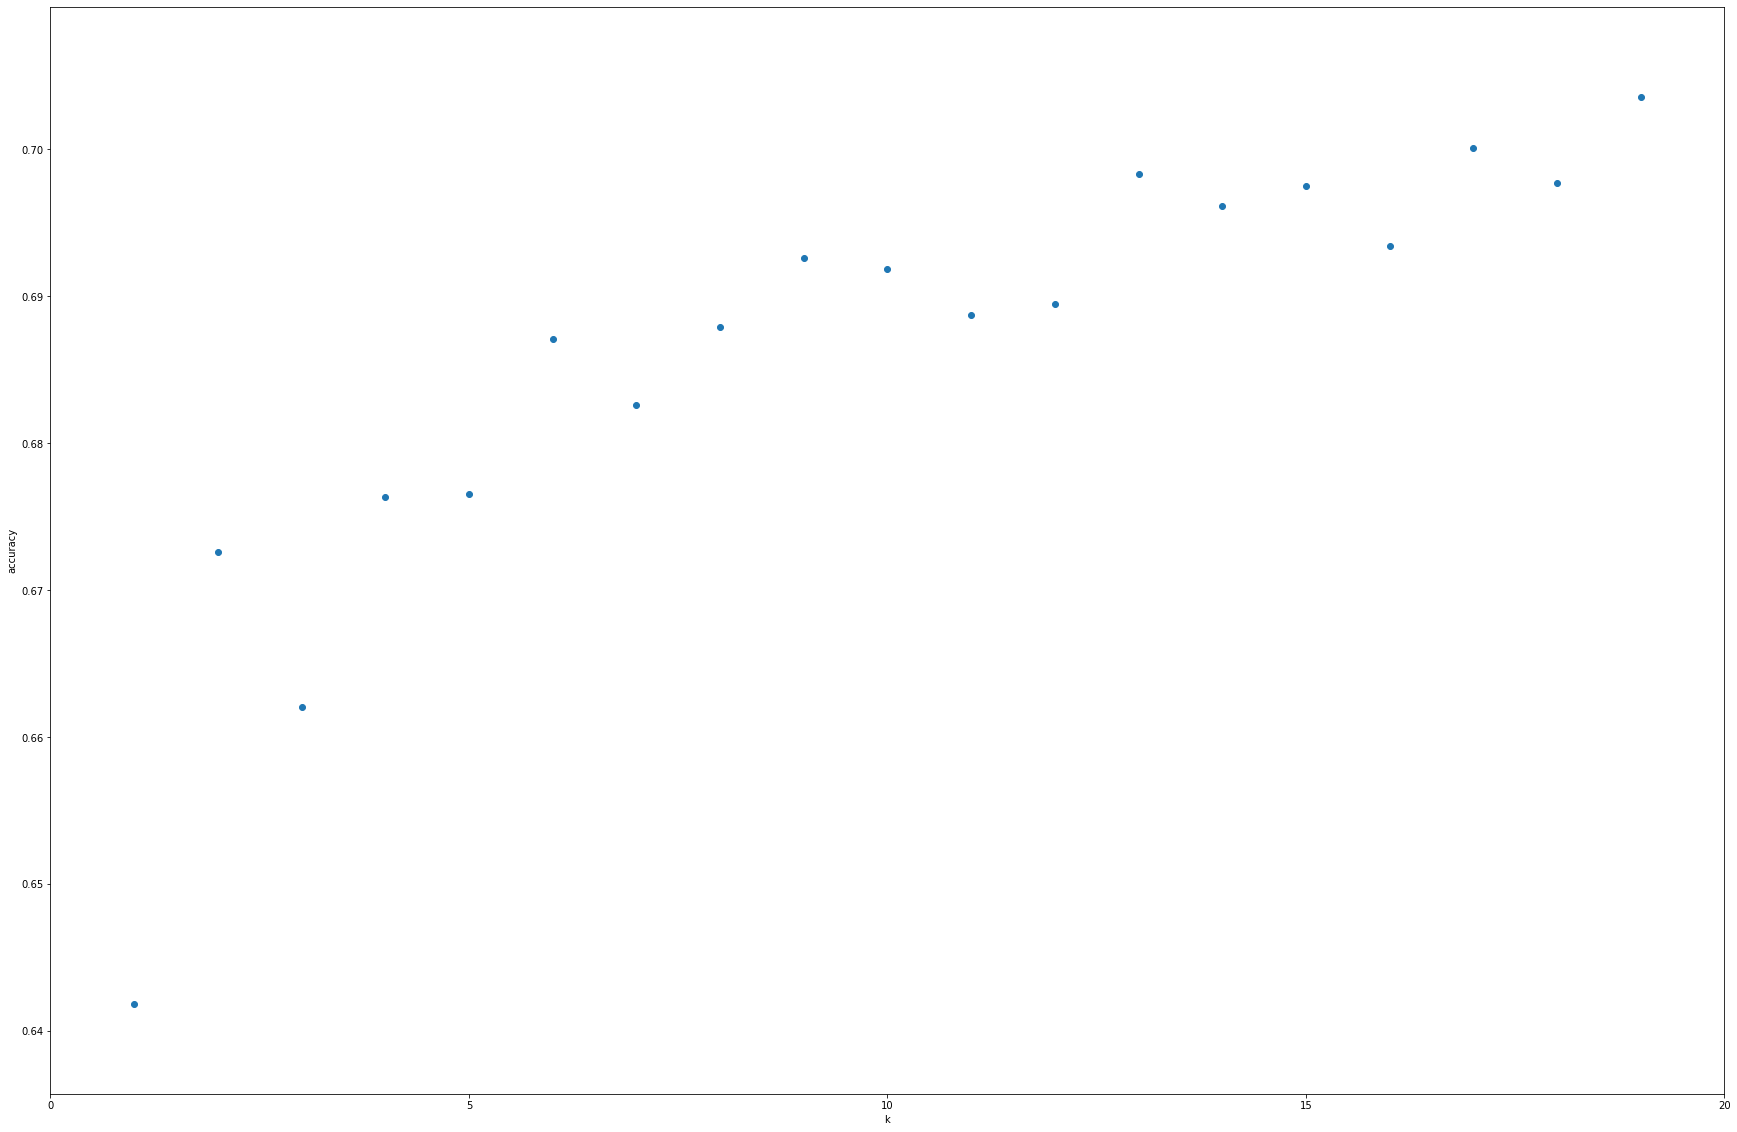

In [46]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

### RFE Feature Engineering

In [47]:
### RFE

number_of_features_list=np.arange(1,29)
high_score=0

#Variable to store the optimum features
number_of_features=10           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LogisticRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 1
Score with 1 features: 0.954323


In [48]:
cols = list(X_train_scaled.columns)
model = LogisticRegression()

#Initializing RFE model
rfe = RFE(model, 10)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['yardsToGo', 'numberOfPassRushers', 'epa', 'playResult', 'RB', 'EMPTY',
       'I_FORM', 'PISTOL', 'SHOTGUN', 'SINGLEBACK'],
      dtype='object')


### Select K Best

In [49]:
f_selector = SelectKBest(f_regression, k=5)

f_selector.fit(X_train_scaled, y_train)

f_support = f_selector.get_support()
f_feature = X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

5 selected features
['down', 'numberOfPassRushers', 'QB_under_pressure', 'epa', 'playResult']


# wangle-functions

In [50]:
#plays["offenseFormation"].replace({"I_FORM": "IFORM"}, inplace=True)

#plays = plays[plays['offenseFormation'].notna()]

#plays = plays[plays['typeDropback'].notna()]

#plays.personnelD.isna().sum()



#ohe = OneHotEncoder(sparse=False)

#ohe.fit_transform(plays[['personnelO']]).shape

#plays['possessionTeam'].replace({'TRADITIONAL':0,'SCRAMBLE_ROLLOUT_RIGHT':1,
#                                 'SCRAMBLE':2,'DESIGNED_ROLLOUT_RIGHT':3,
#                                 'SCRAMBLE_ROLLOUT_LEFT':4,'DESIGNED_ROLLOUT_LEFT':5,
#                                 'UNKNOWN':6}, inplace=True)

#plays['offenseFormation'].replace({'SHOTGUN':0,'SINGLEBACK':1,'EMPTY':2,'I_FORM':3,
#                                   'PISTOL':4,'JUMBO':5,'WILDCAT':6}, inplace=True)

#plays['possessionTeam'].replace({'PIT':0,'GB':1,'TB':2,'IND':3,'ATL':4,'PHI':5,'NYG':6,'DET':7,
#                                'CLE':8,'MIN':9,'LA':10,'OAK':11,'NE':12,'BAL':13,'CAR':14,
#                                'DAL':15,'CIN':16,'DEN':17,'JAX':18,'KC':19,'HOU':20,'WAS':21,
#                                'SF':22,'NYJ':23,'ARI':24,'NO':25,'BUF':26,'CHI':27,'MIA':28,
#                                'LAC':29,'TEN':30,'SEA':31}, inplace=True)

### sklearn pipeline column transformer w/ one hot encoding

In [51]:
#print('Decision Tree with 7 features')
#print('Accuracy:',cross_val_score(estimator = clf, pipe_dt, X_train, y_train, cv=5, n_jobs=4,scoring='accuracy').mean())
#print('Precision:',cross_val_score(pipe_nb, X_train, y_train, cv=5, scoring='precision').mean())
#print('Recall:',cross_val_score(pipe_nb, X_train, y_train, cv=5, scoring='recall').mean())

In [52]:
#models = [GaussianNB(), DecisionTreeClassifier(), SVC(), LogisticRegression(solver='lbfgs')]
#names = ["Naive Bayes", "Decision Tree", "SVM","Logistic Regression"]
#for model, name in zip(models, names):
#    print(name)
#    for score in ["accuracy", "precision", "recall"]:
#        print(score)
#        print (cross_val_score(pipe, X_train, y_train, cv=5, scoring=score).mean())

In [53]:
#y_pred = logit.predict(pipe, X_train)